In [1]:
from google.colab import drive

drive.mount('/gdrive')
%cd /gdrive/MyDrive/[2024-2025]AN2DL/Homework1

Mounted at /gdrive
/gdrive/MyDrive/[2024-2025]AN2DL/Homework1


In [2]:
%%capture
!pip install -r requirements.txt



#Model Training

In [3]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
import keras as tfk
from keras.layers import Input, Dense, Dropout, Lambda, BatchNormalization, Conv2D, MaxPooling2D, Flatten
from keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(f"Tensorflow version -> {tf.__version__}")
print(f"Keras version -> {tfk.__version__}")

# Import other libraries
import requests
from io import BytesIO
import cv2
from PIL import Image
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
import seaborn as sns


# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

Tensorflow version -> 2.17.0
Keras version -> 3.4.1


In [4]:
# load data from file

data = np.load(
        'cleaned_data_dedup.npz'
)
X = data['images']
y = data['labels']


In [5]:
%%capture
!pip install keras_cv
import keras_cv

In [ ]:
#print(X)

In [6]:
class_mapping = {
    0: "Basophil",
    1: "Eosinophil",
    2: "Erythroblast",
    3: "Immature granulocytes",
    4: "Lymphocyte",
    5: "Monocyte",
    6: "Neutrophil",
    7: "Platelet"
}

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=seed, stratify=y_temp)

class_names =  list(class_mapping.values())

y_train = tfk.utils.to_categorical(y_train, num_classes=len(class_names))
y_val = tfk.utils.to_categorical(y_val, num_classes=len(class_names))


##Model Definition 🥇

In [ ]:
## define input and output shapes
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]

print(f'Input shape: {input_shape}')
print(f'Output shape: {output_shape}')

Input shape: (96, 96, 3)
Output shape: (8,)


In [ ]:
## initialize pre-trainned ResNet


# use for the aug for now
ResNet50V2 = tfk.applications.ResNet50V2(
    input_shape=input_shape,
    include_top=False,
    weights='imagenet',
    pooling='avg',
    #include_preprocessing=True
)

ResNet50 = tfk.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=input_shape,
    pooling=None,
    classifier_activation="softmax",
    name="resnet50"
)

EfficientNet = tfk.applications.EfficientNetB7(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=input_shape,
    pooling=None,
)


# Display a summary of the model architecture
# ResNet50V2.summary(expand_nested=True)

#mobile = tfk.applications.MobileNetV3Large(
#    input_shape=input_shape,
#    include_top=False,
#    weights='imagenet',
#    pooling='avg',
#    # include_preprocessing=True
#)

mean_image = np.load('mean_image.npy')
std_image = np.load('std_image.npy')

# Display model architecture with layer shapes and trainable parameters
# tfk.utils.plot_model(InceptionResNetV2, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

In [ ]:
def build_model_with_feature_extractor(input_shape=input_shape, output_shape=output_shape, feature_extractor=ResNet50V2, name="model"):

  feature_extractor.trainable = False

  inputs = tfkl.Input(shape=input_shape, name='input_layer')

  # Apply data augmentation for training robustness
  augmentation = tfk.Sequential([
      # keras_cv.layers.RandomSharpness(0.3, [0, 255]),
      # keras_cv.layers.RandomShear(0.3, 0.3),
      # keras_cv.layers.RandomCutout(0.4, 0.4),
      # keras_cv.layers.AutoContrast([0, 255]),
      tfk.layers.RandomTranslation(0.1, 0.1, fill_mode="constant"),
      tfk.layers.RandomFlip("horizontal_and_vertical"),
      tfk.layers.RandomRotation(0.25, fill_mode="constant"),
      tfk.layers.RandomZoom(0.2, fill_mode="constant"),
      tfk.layers.RandomBrightness(0.1),
      tfk.layers.RandomContrast(0.1)
  ], name='preprocessing')

  x = augmentation(inputs)

  # Pass augmented inputs through the feature_extractor feature extractor
  x = feature_extractor(x) # change to inputs if above is commented

  # Add a dropout layer for regularisation
  x = tfkl.Dropout(0.3, name='dropout')(x)

  x = Dense(128, activation='relu', name="dense_learn")(x)  # Optional dense layer for additional learning capacity

  # Add final Dense layer for classification with softmax activation
  outputs = tfkl.Dense(output_shape[0], activation='softmax', name='dense')(x)

  # Define the complete model linking input and output
  tl_model = tfk.Model(inputs=inputs, outputs=outputs, name=name)

  # Compile the model with categorical cross-entropy loss and Adam optimiser
  #tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])
  tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.RMSprop(), metrics=['accuracy'])


  return tl_model


In [ ]:
def build_basic_conv(input_shape=input_shape, output_shape=output_shape, mean_image=mean_image, std_image=std_image):

  inputs = tfkl.Input(shape=input_shape, name='input_layer')

  # conv layer of 2x2 strides
  x = tfk.layers.Conv2D(filters=16, kernel_size=(2, 2), activation='relu', strides=(2,2))(inputs)

  #batch normalization and dropout
  x = tfk.layers.BatchNormalization()(x)
  x = tfk.layers.Dropout(0.2)(x)

  # conv layer of 8 filters 2x2 strides
  x = tfk.layers.Conv2D(filters=8, kernel_size=(2, 2), activation='relu', strides=(2,2))(x)

  #batch normalization and dropout
  x = tfk.layers.BatchNormalization()(x)
  x = tfk.layers.Dropout(0.2)(x)

  # conv layer of 4 filters 2x2 strides
  x = tfk.layers.Conv2D(filters=8, kernel_size=(2, 2), activation='relu', strides=(2,2))(x)

  #batch normalization and dropout
  x = tfk.layers.BatchNormalization()(x)
  x = tfk.layers.Dropout(0.2)(x)

  flatten = tfkl.Flatten()(x)

  dense = tfkl.Dense(32, activation='softmax', name='dense')(flatten)

  dense2 = tfkl.Dense(16, activation='softmax', name='dense2')(dense)

  outputs = tfkl.Dense(output_shape[0], activation='softmax', name='output')(dense2)

  model = tfk.Model(inputs=inputs, outputs=outputs, name='basic_conv')

  model.compile(
      loss=tfk.losses.CategoricalCrossentropy(),
      optimizer=tfk.optimizers.RMSprop(),
      metrics=['accuracy']
  )

  return model


In [ ]:
def build_basic_gap_conv(input_shape=input_shape, output_shape=output_shape, mean_image=mean_image, std_image=std_image):

  inputs = tfkl.Input(shape=input_shape, name='input_layer')

  augmentation = tfk.Sequential([
      #keras_cv.layers.RandomSharpness(0.3, [0, 255]),
      #keras_cv.layers.RandomShear(0.3, 0.3),
      #keras_cv.layers.RandomCutout(0.4, 0.4),
      #keras_cv.layers.AutoContrast([0, 255]),
      tfk.layers.RandomTranslation(0.1, 0.1, fill_mode="constant"),
      tfk.layers.RandomFlip("horizontal_and_vertical"),
      tfk.layers.RandomRotation(0.25, fill_mode="constant"),
      tfk.layers.RandomZoom(0.2, fill_mode="constant"),
      tfk.layers.RandomBrightness(0.1),
      tfk.layers.RandomContrast(0.1)
  ], name='preprocessing')

  x = augmentation(inputs)

  # conv layer of 2x2 strides
  x = tfk.layers.Conv2D(filters=32, kernel_size=3, activation='relu', strides=(2,2))(x)

  #batch normalization and dropout
  x = tfk.layers.BatchNormalization()(x)
  x = tfk.layers.Dropout(0.2)(x)

  # conv layer of 8 filters 2x2 strides
  x = tfk.layers.Conv2D(filters=16, kernel_size=3, activation='relu', strides=(2,2))(x)

  #batch normalization and dropout
  x = tfk.layers.BatchNormalization()(x)
  x = tfk.layers.Dropout(0.2)(x)

  # conv layer of 4 filters 2x2 strides
  x = tfk.layers.Conv2D(filters=8, kernel_size=3, activation='relu', strides=(2,2))(x)

  #batch normalization and dropout
  x = tfk.layers.BatchNormalization()(x)
  x = tfk.layers.Dropout(0.2)(x)

  gap = tfkl.GlobalAveragePooling2D()(x)

  outputs = tfkl.Dense(output_shape[0], name='Dense_output')(gap)

  outputs = tfkl.Activation('softmax', name='softmax')(outputs)

  model = tfk.Model(inputs=inputs, outputs=outputs, name='basic_conv_gap')

  model.compile(
      loss=tfk.losses.CategoricalCrossentropy(),
      optimizer=tfk.optimizers.RMSprop(),
      metrics=['accuracy']
  )

  return model

In [ ]:
def build_basic_gap_conv2(input_shape=input_shape, output_shape=output_shape, mean_image=mean_image, std_image=std_image):

  inputs = tfkl.Input(shape=input_shape, name='input_layer')

  augmentation = tfk.Sequential([
      keras_cv.layers.RandomSharpness(0.3, [0, 255]),
      keras_cv.layers.RandomShear(0.3, 0.3),
      keras_cv.layers.RandomCutout(0.4, 0.4),
      keras_cv.layers.AutoContrast([0, 255]),
      tfk.layers.RandomTranslation(0.1, 0.1, fill_mode="constant"),
      tfk.layers.RandomFlip("horizontal_and_vertical"),
      tfk.layers.RandomRotation(0.25, fill_mode="constant"),
      tfk.layers.RandomZoom(0.2, fill_mode="constant"),
      tfk.layers.RandomBrightness(0.1),
      tfk.layers.RandomContrast(0.1)
  ], name='preprocessing')

  x = augmentation(inputs)

  # conv layer of 2x2 strides
  x = tfk.layers.Conv2D(filters=32, kernel_size=3, activation='relu', strides=(2,2))(x)

  #batch normalization and dropout
  x = tfk.layers.BatchNormalization()(x)
  x = tfk.layers.Dropout(0.2)(x)

  # conv layer of 8 filters 2x2 strides
  x = tfk.layers.Conv2D(filters=64, kernel_size=3, activation='relu', strides=(2,2))(x)

  #batch normalization and dropout
  x = tfk.layers.BatchNormalization()(x)
  x = tfk.layers.Dropout(0.2)(x)

  # conv layer of 4 filters 2x2 strides
  x = tfk.layers.Conv2D(filters=128, kernel_size=3, activation='relu', strides=(2,2))(x)


  #batch normalization and dropout
  x = tfk.layers.BatchNormalization()(x)
  x = tfk.layers.Dropout(0.2)(x)

   # conv layer of 4 filters 2x2 strides
  x = tfk.layers.Conv2D(filters=216, kernel_size=3, activation='relu', strides=(2,2))(x)

  #batch normalization and dropout
  x = tfk.layers.BatchNormalization()(x)
  x = tfk.layers.Dropout(0.2)(x)

   # conv layer of 4 filters 2x2 strides
  x = tfk.layers.Conv2D(filters=512, kernel_size=3, activation='relu', strides=(2,2))(x)

  #batch normalization and dropout
  x = tfk.layers.BatchNormalization()(x)
  x = tfk.layers.Dropout(0.2)(x)

  gap = tfkl.GlobalAveragePooling2D()(x)

  outputs = tfkl.Dense(output_shape[0], name='Dense_output')(gap)

  outputs = tfkl.Activation('softmax', name='softmax')(outputs)

  model = tfk.Model(inputs=inputs, outputs=outputs, name='basic_conv_gap2')

  model.compile(
      loss=tfk.losses.CategoricalCrossentropy(),
      optimizer=tfk.optimizers.RMSprop(),
      metrics=['accuracy']
  )

  return model

In [ ]:
def resNet_without_aug(input_shape=input_shape, output_shape=output_shape, name="ResNet50_no_aug"):

  augmentation = tfk.Sequential([
      keras_cv.layers.RandomSharpness(0.3, [0, 255]),
      keras_cv.layers.RandomShear(0.3, 0.3),
      keras_cv.layers.RandomCutout(0.4, 0.4),
      keras_cv.layers.AutoContrast([0, 255]),
      tfk.layers.RandomTranslation(0.1, 0.1, fill_mode="constant"),
      tfk.layers.RandomFlip("horizontal_and_vertical"),
      tfk.layers.RandomRotation(0.25, fill_mode="constant"),
      tfk.layers.RandomZoom(0.2, fill_mode="constant"),
      tfk.layers.RandomBrightness(0.1),
      tfk.layers.RandomContrast(0.1),

  ], name='preprocessing')

  # augmentation = keras_cv.layers.AugMix(
  #         [-123.68,151.061],
  #         # severity=0.3,
  #         # num_chains=5,
  #         # chain_depth=[1, 5],
  #         # alpha=1.0,
  #         # seed=None
  # )

  inputs = tfkl.Input(shape=input_shape, name='input_layer')

  x = augmentation(inputs)

  x = ResNet50(x)

  x = tfk.layers.GlobalAveragePooling2D()(x)

  x = tfk.layers.BatchNormalization()(x)
  x = tfk.layers.Dropout(0.2)(x)

  x = Dense(128, activation='relu')(x)  # Optional dense layer for additional learning capacity

  x = tfk.layers.BatchNormalization()(x)
  x = tfk.layers.Dropout(0.2)(x)

  predictions = Dense(8, activation='softmax')(x)  # Adjusted to 8 classes

  # Create a new model with these layers
  model = tfk.Model(inputs=inputs, outputs=predictions, name=name)

  # Optionally, freeze layers of the base model if needed
  for layer in ResNet50.layers:
      layer.trainable = False

  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  return model

In [ ]:
def efficientNet_tl(input_shape=input_shape, output_shape=output_shape, name="EfficientNet"):

  augmentation = tfk.Sequential([
      #keras_cv.layers.RandomSharpness(0.3, [0, 255]),
      #keras_cv.layers.RandomShear(0.3, 0.3),
      #keras_cv.layers.RandomCutout(0.4, 0.4),
      #keras_cv.layers.AutoContrast([0, 255]),
      tfk.layers.RandomTranslation(0.1, 0.1, fill_mode="constant"),
      tfk.layers.RandomFlip("horizontal_and_vertical"),
      tfk.layers.RandomRotation(0.25, fill_mode="constant"),
      tfk.layers.RandomZoom(0.2, fill_mode="constant"),
      #tfk.layers.RandomBrightness(0.1),
      #tfk.layers.RandomContrast(0.1),
  ], name='preprocessing')


  inputs = tfkl.Input(shape=input_shape, name='input_layer')

  #x = inputs
  x = augmentation(inputs)


  x = EfficientNet(x)

  x = tfk.layers.GlobalAveragePooling2D()(x)

  x = tfk.layers.BatchNormalization()(x)
  x = tfk.layers.Dropout(0.2)(x)

  x = Dense(128, activation='relu')(x)  # Optional dense layer for additional learning capacity

  x = tfk.layers.BatchNormalization()(x)
  x = tfk.layers.Dropout(0.2)(x)

  predictions = Dense(8, activation='softmax')(x)  # Adjusted to 8 classes

  # Create a new model with these layers
  model = tfk.Model(inputs=inputs, outputs=predictions, name=name)

  # Optionally, freeze layers of the base model if needed
  for layer in EfficientNet.layers:
      layer.trainable = False

  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  return model

In [ ]:
def fine_tune_resnet50():
    ft_model = tfk.models.load_model('ResNet50_no_aug_76.78.keras')

    ft_model.get_layer('resnet50').trainable = True

    # Set all MobileNetV3Small layers as non-trainable
    for layer in ft_model.get_layer('resnet50').layers:
        layer.trainable = False

    # Enable training only for Conv2D and DepthwiseConv2D layers
    for i, layer in enumerate(ft_model.get_layer('resnet50').layers):
        if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.DepthwiseConv2D):
            layer.trainable = True
            print(i, layer.name, type(layer).__name__, layer.trainable)

    N_freeze = 124

    for layer in ft_model.get_layer('resnet50').layers[:N_freeze]:
        layer.trainable = False
        print(layer.name, layer.trainable)

    ft_model.compile(
        loss=tfk.losses.CategoricalCrossentropy(),
        optimizer=tfk.optimizers.RMSprop(learning_rate = 1e-4),
        metrics=['accuracy']
    )

    return ft_model


In [ ]:
def fine_tune_effNet():
    ft_model = tfk.models.load_model('EfficientNet_99.15.keras')

    ft_model.get_layer('efficientnetb0').trainable = True

    # Set all MobileNetV3Small layers as non-trainable
    for layer in ft_model.get_layer('efficientnetb0').layers:
        layer.trainable = False

    # Enable training only for Conv2D and DepthwiseConv2D layers
    for i, layer in enumerate(ft_model.get_layer('efficientnetb0').layers):
        if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.DepthwiseConv2D):
            layer.trainable = True
            print(i, layer.name, type(layer).__name__, layer.trainable)

    N_freeze = 124

    for layer in ft_model.get_layer('efficientnetb0').layers[:N_freeze]:
        layer.trainable = False
        print(layer.name, layer.trainable)

    ft_model.compile(
        loss=tfk.losses.CategoricalCrossentropy(),
        optimizer=tfk.optimizers.RMSprop(learning_rate = 1e-4),
        metrics=['accuracy']
    )

    return ft_model


In [ ]:
# incResNet = build_model_with_feature_extractor(name='ResNet50V2_aug_data')
# incResNet.summary()

#mobile = build_model_with_feature_extractor(name='MobileNetV3Large_aug')
#mobile.summary()

# incResNetNoAug = resNet_without_aug(name='ResNet50_no_aug')
# incResNetNoAug.summary()

## basicModel = build_basic_conv()
## basicModel.summary()
##
## basic_with_gap = build_basic_gap_conv()
## basic_with_gap.summary()
##
##
# basic_with_gap2 = build_basic_gap_conv2()
# basic_with_gap2.summary()
#
# fine_tune = fine_tune_resnet50()
# fine_tune.summary()

efficientNet = efficientNet_tl()
efficientNet.summary()

#ft_effNet = fine_tune_effNet()
#ft_effNet.summary()

#

Model: "EfficientNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ preprocessing (Sequential)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb7 (Functional)          │ (None, 3, 3, 2560)          │      64,097,687 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2560)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 2560)                │          10,240 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2560)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         327,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 64,437,279 (245.81 MB)

 Trainable params: 64,121,176 (244.60 MB)

 Non-trainable params: 316,103 (1.21 MB)

In [ ]:
## define callbacks

callbacks = [
    tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True),
    # tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience=3, factor=0.5, min_lr=1e-5)
]


### Train and save the model

In [ ]:
from keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define your batch size
batch_size = 32

# Initialize ImageDataGenerator with preprocessing for ResNet50

datagen = ImageDataGenerator() # For Efficient
#datagen = ImageDataGenerator(preprocessing_function=preprocess_input) # for RESNET
# datagen = ImageDataGenerator(
#     preprocessing_function=preprocess_input,
#     rescale=1.0/255,
#     rotation_range=40,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )

# Define the generators using the split indices
train_generator = datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = datagen.flow(X_val, y_val, batch_size=batch_size)
test_generator = datagen.flow(X_test, tfk.utils.to_categorical(y_test, num_classes=8), batch_size=10)

BATCH_SIZE = batch_size
NUM_CLASSES = 8
augmenter = keras_cv.layers.Augmenter(
    [
        keras_cv.layers.RandomFlip(),
        keras_cv.layers.RandAugment(value_range=(0, 255)),
        keras_cv.layers.CutMix(),
    ],
)

def augment(images, y):
    inputs = {"images": images, "labels": y}
    output = augmenter(inputs)

    return output

def process_validation(images, y):
    return {"images": images, "labels": y}

def make_dataset(X, y, mode="train", batch_size=256):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if mode == "train":
        ds = ds.shuffle(batch_size * 4)
    ds = ds.batch(batch_size)
    if mode == "train":
        ds = ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
    else:
        ds = ds.map(process_validation, num_parallel_calls=tf.data.AUTOTUNE)
        ds = ds.cache()
    #ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_dataset(X_train, y_train)
valid_ds = make_dataset(X_val, y_val, mode="valid")

#

In [ ]:
def show_images(images, row, col):
    fig, axs = plt.subplots(row, col, figsize=(10, 10))
    for i in range(row):
        for j in range(col):
            axs[i, j].imshow(images[i * row + j]/255)
            axs[i, j].axis("off")
    plt.show()

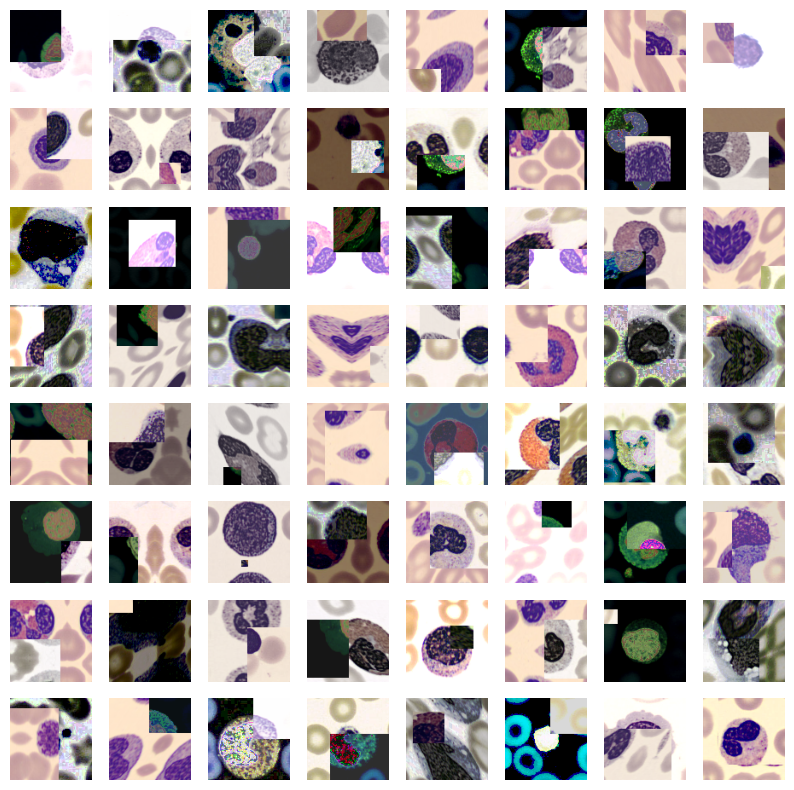

In [ ]:
for X in train_ds.take(1):
    show_images(X["images"], 8, 8)

In [ ]:
model = efficientNet

def preprocess_for_model(inputs):
    images, labels = inputs["images"], inputs["labels"]
    images = tf.cast(images, tf.float32)
    return images, labels

train_ds = train_ds.map(preprocess_for_model, num_parallel_calls=tf.data.AUTOTUNE)
valid_ds = valid_ds.map(preprocess_for_model, num_parallel_calls=tf.data.AUTOTUNE)

train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
valid_ds = valid_ds.prefetch(tf.data.AUTOTUNE)


history = model.fit(
    train_ds,
    # batch_size=32,
    epochs=300,
    validation_data=valid_ds,
    callbacks=callbacks
).history

# Calculate and print the best validation accuracy achieved
final_val_accuracy = round(max(history['val_accuracy']) * 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')


file_name = model.name + "_" + str(final_val_accuracy) + '.keras'

## save model and free memory
model.save(file_name)
# del model

HERE
HERE
Epoch 1/300


ResourceExhaustedError: Graph execution error:

Detected at node EfficientNet_1/efficientnetb7_1/block3c_dwconv_1/depthwise defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-26-6df6a74f931f>", line 18, in <cell line: 18>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 320, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 108, in one_step_on_data

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 51, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py", line 899, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py", line 182, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/function.py", line 171, in _run_through_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py", line 584, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py", line 899, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py", line 182, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/function.py", line 171, in _run_through_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py", line 584, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py", line 899, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_depthwise_conv.py", line 204, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py", line 999, in depthwise_conv

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py", line 313, in depthwise_conv

OOM when allocating tensor with shape[256,12,12,480] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node EfficientNet_1/efficientnetb7_1/block3c_dwconv_1/depthwise}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_one_step_on_iterator_175355]

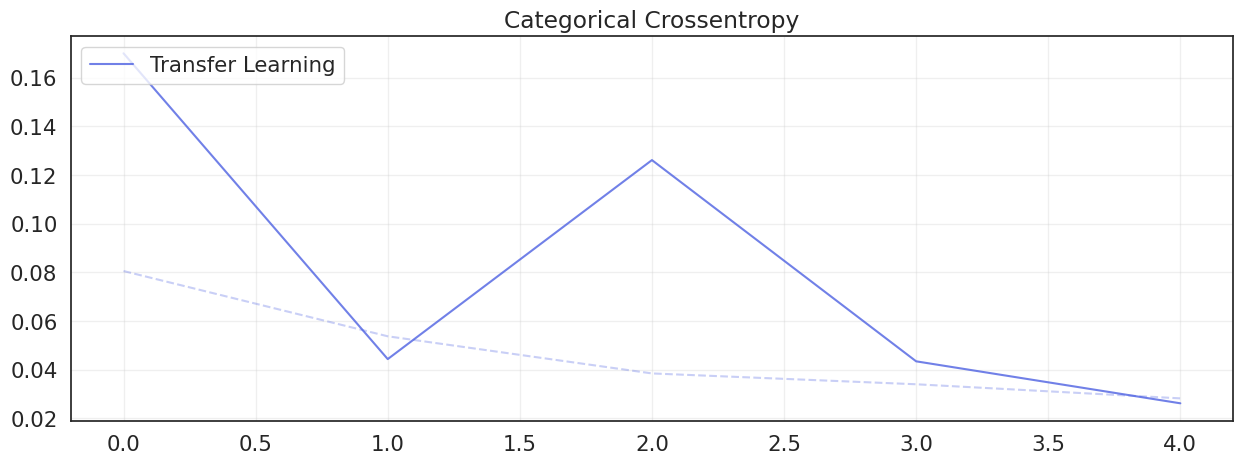

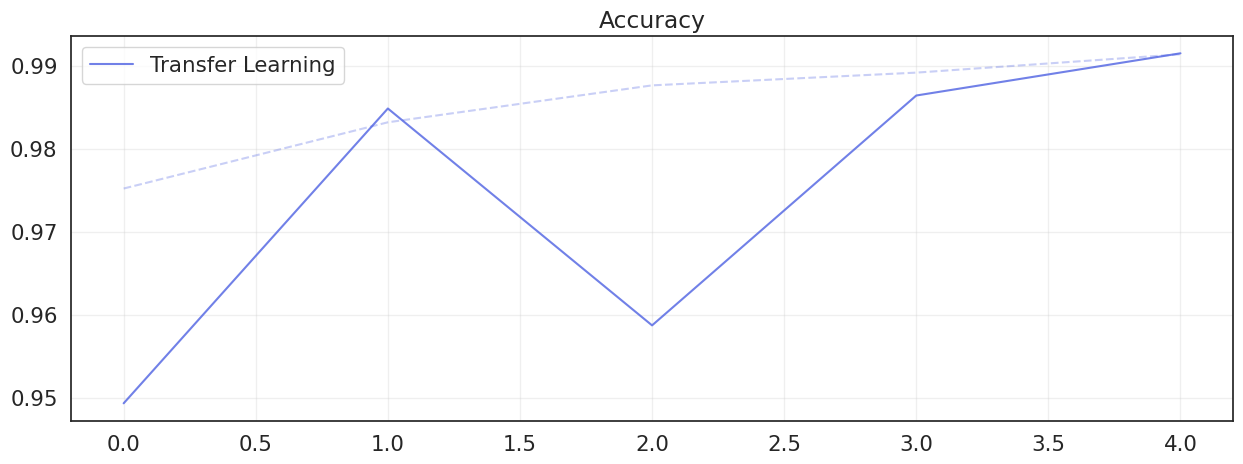

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history['val_loss'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history['val_accuracy'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

### Test on unseen data

In [ ]:
# Normalize the test data using the training set mean and std

# evaluate a model on a dataset using test-time augmentation
# def tta_prediction(datagen, model, n_examples, image):
#
#   exp = np.expand_dims(image, axis=0)
#
#   it = datagen.flow(exp, batch_size=n_examples)
#
# 	# make predictions for each augmented image
#   yhats = model.predict(it, steps=n_examples, verbose=0)
#
# 	# sum across predictions
#   summed = np.sum(yhats, axis=0)
#
# 	# argmax across classes
#
#   return np.argmax(summed)
#
# # counts
# predsTta = np.array([])
# for i in range(len(X_test)):
#   image = X_test[i]
#
#   predsTta = np.append(predsTta, tta_prediction(datagen, model, 10, image))
#
# print(f"ACC: {np.mean(predsTta == y_test.flatten())}")





# _X_test = (X_test - mean_image) / std_image
#_X_test = preprocess_input(X_test) # ... for ResNet
_X_test = (X_test)

# Make predictions
preds = model.predict(_X_test)

# Get the predicted class for each test example
preds = np.argmax(preds, axis=1)

#print all unique values in preds
print(np.unique(preds))
print(np.unique(y_test))

# Calculate accuracy
# TODOOOOOO: this formula is wrong!!!!

accuracy = np.mean(preds == y_test)  # y_test should be the true labels
print(f"Accuracy: {accuracy * 100:.2f}%")


accuracy = np.mean(preds == y_test.flatten())  # y_test should be the true labels
print(f"Accuracy: {accuracy * 100:.2f}%")



400/400 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step
[0 1 2 3 4 5 6 7]
[0 1 2 3 4 5 6 7]
Accuracy: 14.45%
Accuracy: 99.14%


In [ ]:
# perform tta

average_pred = []
for i in range(10):
    preds = model.predict(_X_test)
    average_pred.append(preds)

average_pred = np.mean(average_pred, axis=0)
preds = np.argmax(average_pred, axis=1)

accuracy = np.mean(preds == y_test.flatten())  # y_test should be the true labels
print(f"Accuracy: {accuracy * 100:.2f}%")

400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
Accuracy: 99.14%


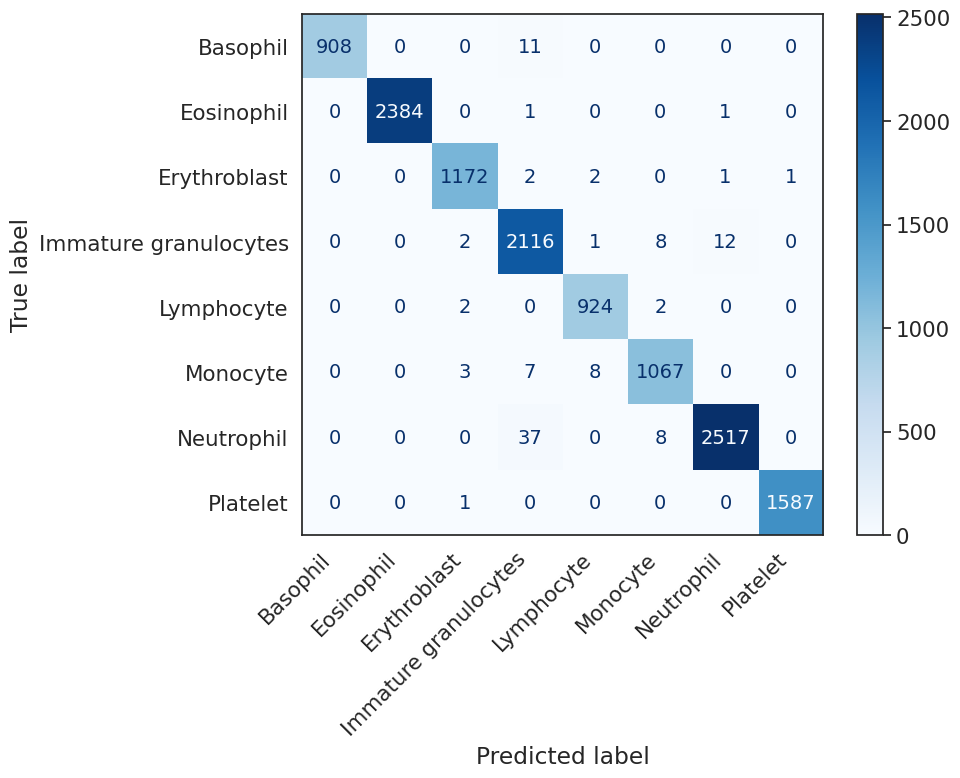

In [ ]:
## display a correlation matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calculate the confusion matrix
cm = confusion_matrix(y_test, preds)

# Set up the figure size
plt.figure(figsize=(10, 8))

# Display the confusion matrix with rotated labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, ax=plt.gca())
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels
plt.yticks(rotation=0)  # Keep y-axis labels horizontal

# Adjust layout
plt.tight_layout()
plt.show()

## 📊 Prepare Your Submission

To prepare your submission, create a `.zip` file that includes all the necessary code to run your model. It **must** include a `model.py` file with the following class:

```python
# file: model.py
class Model:
    def __init__(self):
        """Initialize the internal state of the model."""

    def predict(self, X):
        """Return a numpy array with the labels corresponding to the input X."""
```

The next cell shows an example implementation of the `model.py` file, which includes loading model weights from the `weights.keras` file and conducting predictions on provided input data. The `.zip` file is created and downloaded in the last notebook cell.

❗ Feel free to modify the method implementations to better fit your specific requirements, but please ensure that the class name and method interfaces remain unchanged.

In [42]:
%ls

 basic_conv_gap2_89.91.keras              FocalCELoss.keras
 cleaned_data_dedup_balanced.npz          FOCAL-EfficientNet_85.13.keras
 cleaned_data_dedup.npz                   FOCAL_Fine_Fine_tuneEfficientNet_98.38.keras
 cleaned_data.npz                         FOCAL_Fine_tuneEfficientNet_98.44.keras
 CreateTestingSet.ipynb                   Focal_loss.ipynb
 cut_mix_mix_up_and_rand_augment.ipynb   'Homework 1 - Melvin.ipynb'
 Data_cleaning.ipynb                      Homework_1_MobileNetV2.ipynb
 deduplicated_balanced_training_set.npz   mean_image.npy
 deduplicated_training_set.npz            model.py
 EfficientNet_84.2.keras                  ModelTraining.ipynb
 EfficientNet_96.19.keras                 prediction.txt
 EfficientNet_99.15.keras                 __pycache__/
 Final_tuned_for_3.keras                  requirements.txt
 Fine_Fine_tuneEfficientNet_98.78.keras   std_image.npy
 Fine_tune_class3.ipynb                   training_set.npz
 Fine_tuneEfficientNet_98.7.keras         t

In [1]:
%%writefile model.py
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras_cv
import sys

import random
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 32

def to_dict(image):
    #image = tf.image.resize(image, IMAGE_SIZE)
    image = tf.cast(image, tf.float32)

    return {"images": image}



def prepare_dataset(dataset, split):
        return dataset.map(to_dict, num_parallel_calls=AUTOTUNE)


def load_dataset(X, split="train"):
    dataset = tf.data.Dataset.from_tensor_slices((X)).batch(BATCH_SIZE)
    return prepare_dataset(dataset, split)


class Model:
    def __init__(self):
        """
        Initialize the internal state of the model. Note that the __init__
        method cannot accept any arguments.

        The following is an example loading the weights of a pre-trained
        model.
        """
        #self.neural_network1 = tfk.models.load_model('FOCAL_Fine_tuneEfficientNet_98.44.keras', compile=False)
        self.neural_network1 = tfk.models.load_model('FinalEfficientNet_98.09.keras', compile=False)
        #self.neural_network3 = tfk.models.load_model('Final_tuned_for_3.keras', compile=False)

    def apply_color_replacement(self, X, target_color=np.array([230, 192, 183]), replacement_color=np.array([253, 225, 201]), threshold=60):
        # Calculate the Euclidean distance across the entire dataset in a vectorized manner
        distances = np.linalg.norm(X - target_color, axis=-1)

        # Create a mask for all pixels that are within the threshold distance to the target color
        mask = distances < threshold

        # Broadcast the replacement_color over the RGB channels where the mask is True
        X[mask] = replacement_color

        return X


    def predict(self, X):
        """
        Predict the labels corresponding to the input X. Note that X is a numpy
        array of shape (n_samples, 96, 96, 3) and the output should be a numpy
        array of shape (n_samples,). Therefore, outputs must no be one-hot
        encoded.

        The following is an example of a prediction from the pre-trained model
        loaded in the __init__ method.
        """
        # X = self.apply_color_replacement(X)
        # X_norm = preprocess_input(X)


        def preprocess_for_model(inputs):
          images = inputs["images"]
          images = tf.cast(images, tf.float32)
          return images

        rand_augment = keras_cv.layers.RandAugment(
            value_range=(0, 255),
            augmentations_per_image=3,
            magnitude=0.3,
            magnitude_stddev=0.2,
            rate=1.0,
        )

        def apply_rand_augment(inputs):
          print(inputs)
          inputs["images"] = rand_augment(inputs["images"])
          return inputs

        def reinforce_TTA(model, model2, X_t):

          ds = load_dataset(X_t, split="test")
          ds = ds.map(apply_rand_augment, num_parallel_calls=AUTOTUNE).map(preprocess_for_model, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

          average_pred = []
          for i in range(10): # not perfoming tta at the moment
              preds = model.predict(ds)
              average_pred.append(preds)

              # preds = model2.predict(ds)
              # average_pred.append(preds)

              #preds = model3.predict(ds)
              #average_pred.append(preds)

          average_pred = np.mean(average_pred, axis=0)

          return average_pred


        X_ds = load_dataset(X, split="test")
        X_ds = X_ds.map(apply_rand_augment, num_parallel_calls=AUTOTUNE).map(preprocess_for_model, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)


        average_pred = []
        for i in range(10):
            preds = self.neural_network1.predict(X_ds)
            average_pred.append(preds)

            # preds = self.neural_network2.predict(X_ds)
            # average_pred.append(preds)


        average_pred = np.mean(average_pred, axis=0)

        ## max min cofidence
        max_min_cofidence = np.max(average_pred, axis=1)

        # for confidence < 0.85, do more tta and apply the medium
        # indices_to_get_cofidence = np.where(max_min_cofidence < 0.85)
        # average_pred[indices_to_get_cofidence] = reinforce_TTA(self.neural_network1, self.neural_network2, X[indices_to_get_cofidence])


        preds = np.argmax(average_pred, axis=1)

        #preds = self.tta_prediction(self.neural_network1, X_norm)
        #preds = np.argmax(preds, axis=-1)

        return preds

Writing model.py


In [ ]:

print (X_test.shape)
print (y_test.shape)

(7357, 96, 96, 3)
(7357, 1)


In [64]:

model = Model()
preds = model.predict(X_test)

{'images': <tf.Tensor 'args_0:0' shape=(None, 96, 96, 3) dtype=float32>}
37/37 ━━━━━━━━━━━━━━━━━━━━ 31s 446ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 36s 575ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 31s 450ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step


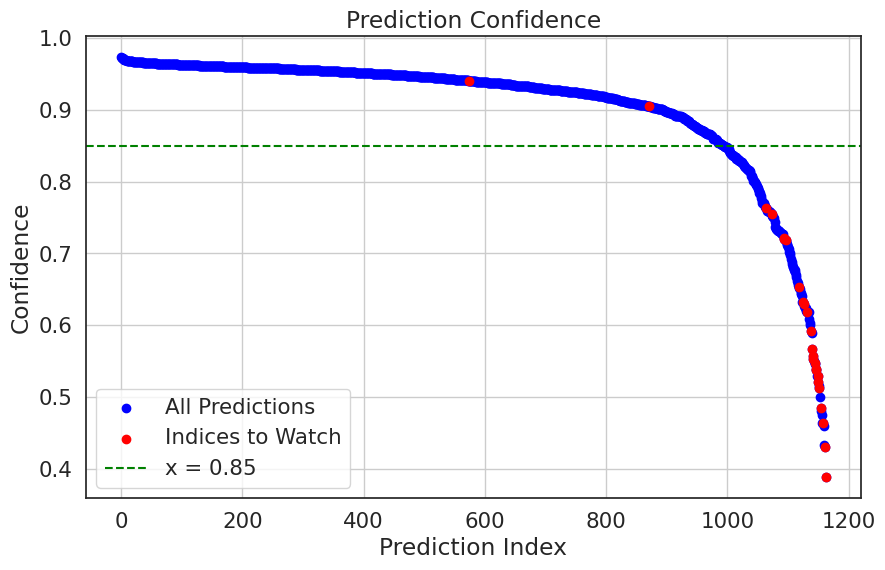

168
59
23
18


In [ ]:
# plot the cofidence over the prediction in a graph
import matplotlib.pyplot as plt

indices_to_watch = [ 111,  191,  219,  327,  374,  382,  387,  424,  429,  539,  599,
        616,  738,  800,  805,  826,  869,  942,  957,  962, 1002, 1021,
       1029, 1081, 1104]


import matplotlib.pyplot as plt
import numpy as np

# Assuming you have 'plot_preds' (confidence values) and 'indices_to_watch' defined

sorted_indices = np.argsort(plot_preds)[::-1]
sorted_plot_preds = plot_preds[sorted_indices]

# Adjust indices_to_watch to reflect the new sorted order
sorted_indices_to_watch = [np.where(sorted_indices == i)[0][0] for i in indices_to_watch]


# Create a scatter plot
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.scatter(range(len(sorted_plot_preds)), sorted_plot_preds, color='blue', label='All Predictions')

# Highlight the specified indices in a different color
plt.scatter(sorted_indices_to_watch, sorted_plot_preds[sorted_indices_to_watch], color='red', label='Indices to Watch')
plt.axhline(y=0.85, color='green', linestyle='--', label='x = 0.85')
plt.xlabel('Prediction Index')
plt.ylabel('Confidence')
plt.title('Prediction Confidence')
plt.legend()
plt.grid(True)
plt.show()

# how many values are bellow 0.85 and 0.7 ... and how many of those are wrong guesses
print(np.sum(sorted_plot_preds < 0.85))
print(np.sum(sorted_plot_preds < 0.7))
print(np.sum(sorted_plot_preds[sorted_indices_to_watch] < 0.85))
print(np.sum(sorted_plot_preds[sorted_indices_to_watch] < 0.7))




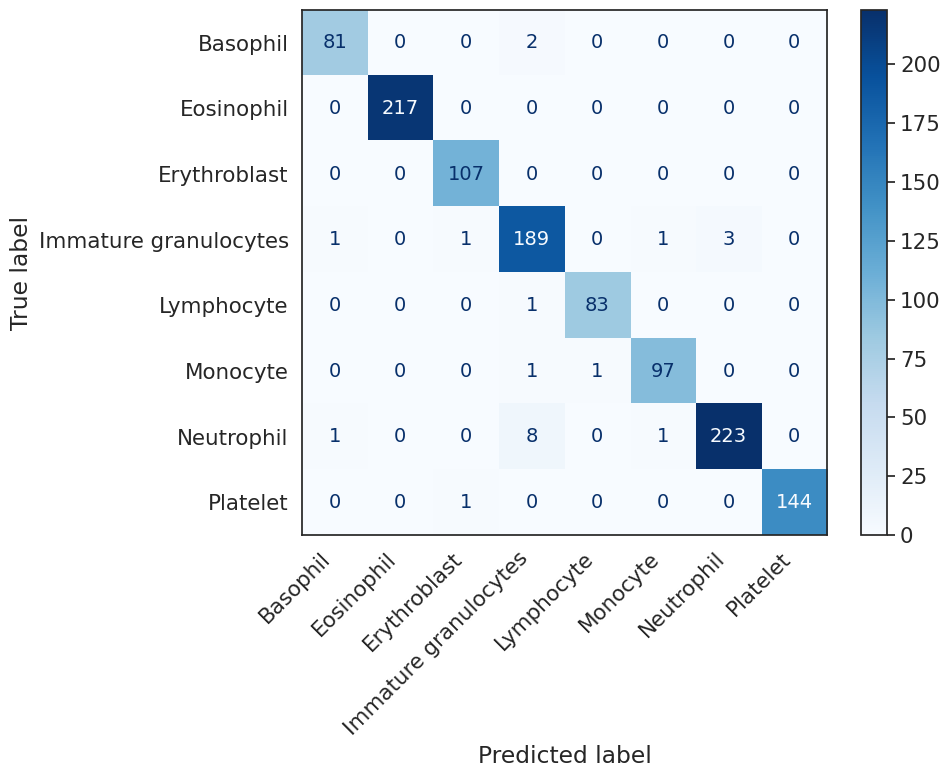

In [56]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

class_mapping = {
    0: "Basophil",
    1: "Eosinophil",
    2: "Erythroblast",
    3: "Immature granulocytes",
    4: "Lymphocyte",
    5: "Monocyte",
    6: "Neutrophil",
    7: "Platelet"
}

class_names =  list(class_mapping.values())

cm = confusion_matrix(y_test, preds)

# Set up the figure size
plt.figure(figsize=(10, 8))

# Display the confusion matrix with rotated labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, ax=plt.gca())
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels
plt.yticks(rotation=0)  # Keep y-axis labels horizontal

# Adjust layout
plt.tight_layout()
plt.show()

In [66]:
#print(preds)
#print(y_test.flatten())
print(preds)
accuracy = np.mean(preds == y_test.flatten())  # y_test should be the true labels
print(f"Accuracy: {accuracy * 100:.2f}%")

[2 6 1 ... 6 5 6]
Accuracy: 98.11%


In [ ]:
# print the indices of
print(np.where(preds != y_test.flatten()))
indices_to_watch = np.where(preds != y_test.flatten())

X_watch = X_test[indices_to_watch]
y_watch = y_test[indices_to_watch]

(array([ 109,  191,  219,  327,  374,  382,  424,  429,  462,  539,  599,
        616,  800,  805,  826,  957,  988, 1002, 1029, 1104]),)


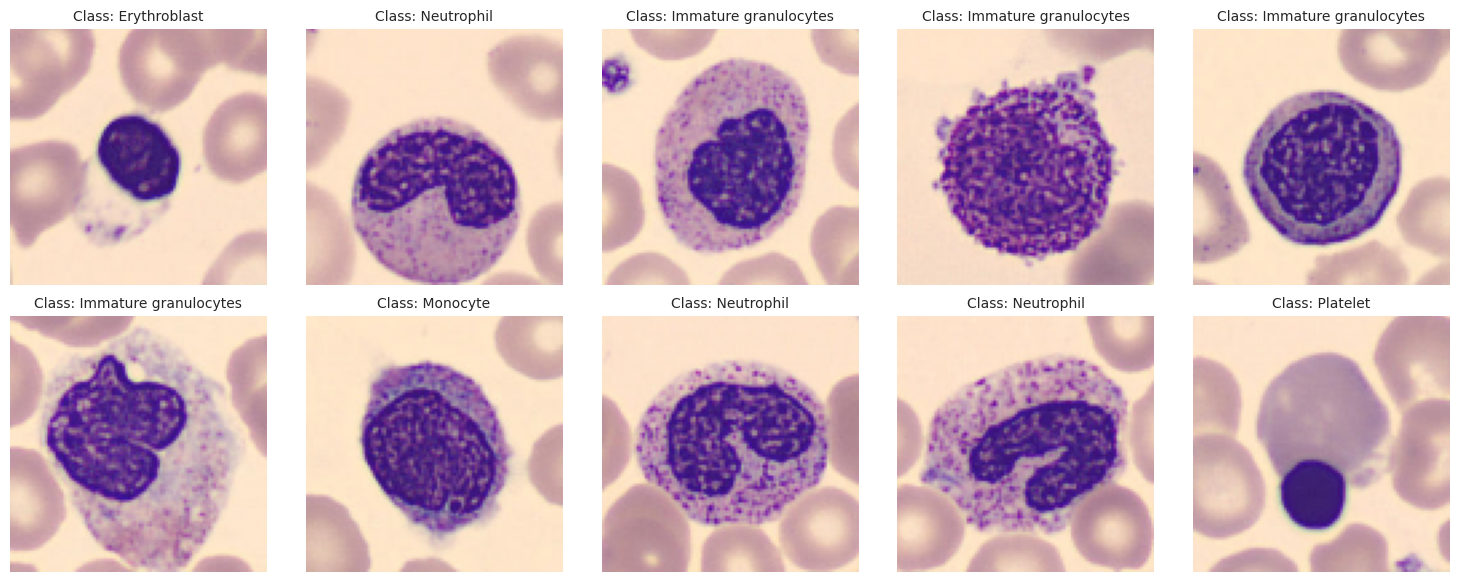

In [ ]:
# print images on the indices
import matplotlib.pyplot as plt

def print_images_with_labels(X, y, num_images=10):
  # Define number of columns (fixed to 5, for example)
  num_columns = 5
  # Calculate number of rows based on the number of images
  num_rows = (num_images + num_columns - 1) // num_columns  # This rounds up

  # Create a grid of subplots (dynamically adjusting the number of rows)
  fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 3 * num_rows))

  # Flatten axes to make it easier to iterate over them
  axes = axes.flatten()

  # Loop through the images and display them with their class labels
  for i in range(num_images):
      ax = axes[i]
      ax.imshow(X[i])  # Show the image

      # Ensure y[i] is a scalar value (in case it's an array)
      label = y[i] if isinstance(y[i], (int, np.integer)) else y[i].item()  # Convert to scalar if it's an array
      ax.set_title(f'Class: {class_mapping.get(label, "Unknown")}', fontsize=10)  # Get class name from mapping
      ax.axis('off')  # Hide axis ticks for better display

  plt.tight_layout()  # Adjust the layout to avoid overlap
  plt.show()

print_images_with_labels(X_watch, y_watch, num_images=10)


In [ ]:
#del model

In [ ]:
from datetime import datetime
filename = f'submission_{datetime.now().strftime("%y%m%d_%H%M%S")}.zip'

# # Add files to the zip command if needed
!zip {filename} model.py "Fine_Fine_tuneEfficientNet_98.78.keras" # "mean_image.npy" "std_image.npy"
##
from google.colab import files
files.download(filename)

  adding: model.py (deflated 68%)
  adding: Fine_tuneEfficientNet_98.7.keras (deflated 8%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>